In [1]:
import numpy as np, pandas as pd, pickle, matplotlib.pyplot as plt

In [2]:
union_of_covariate_sets = dict()
union_of_covariate_sets['Motor'] = ['NUPDRS2_DAILYACT', 'NUPDRS3_GAIT', 'NUPDRS3_RIGID_RIGHT', 'NUPDRS3_FACE', \
                                    'NUPDRS3_TREMOR', 'NUPDRS3_RIGID_LEFT', 'NHY']
# questions + total should have same availabilities
union_of_covariate_sets['Cognitive'] = ['MOCA', 'HVLT_discrim_recog', 'HVLT_immed_recall', 'HVLT_retent', 'BJLO', 'LNS', \
                                        'SEMANTIC_FLUENCY', 'NP1COG']
union_of_covariate_sets['Autonomic'] = ['SCOPA-AUT', 'MedHist_1i. gastrointestinal', 'DIASUP', 'DIASTND', 'SYSSTND', \
                                        'SYSSUP', 'NP1URIN', 'NP1LTHD', 'NP1FATG', 'NP1PAIN', 'NP1CNST', 'BMI', \
                                        'DIGESTIVE AID']
union_of_covariate_sets['Psychiatric'] = ['STAI', 'QUIP', 'GDSSHORT', 'PhysExam_Psychiatric', 'RAWHITE', 'NP1HALL', \
                                          'NP1DPRS', 'NP1ANXS', 'NP1APAT', 'MedHist_1q. psychiatric', \
                                          'ANTIDEPRESSANT', 'ANXIOLYTIC']
union_of_covariate_sets['Sleep'] = ['EPWORTH', 'REMSLEEP', 'NP1SLPN', 'NP1SLPD', 'SLEEP AID']
union_of_covariate_sets['All'] = ['AGE', 'MALE', 'UPSIT', 'GENETIC_RISK_SCORE', 'DIS_DUR_BY_CONSENTDT']
union_of_covariate_sets['CSF'] = ['PTAU_ABETA_ratio', 'TTAU_ABETA_ratio', 'PTAU_TTAU_ratio', 'ASYNU_log', \
                                  'TTAU_log', 'ABETA_log', 'PTAU_log']
union_of_covariate_sets['Imaging'] = ['count_density_ratio_ipsilateral', 'count_density_ratio_contralateral', \
                                      'ipsilateral_caudate', 'ipsilateral_putamen', 'contralateral_caudate', \
                                      'contralateral_putamen', 'asymmetry_index_caudate', 'asymmetry_index_putamen']
        

In [3]:
baseline_covariate_sets = dict()
baseline_covariate_sets['Motor'] = ['NUPDRS2_DAILYACT', 'NUPDRS3_GAIT', 'NUPDRS3_RIGID_RIGHT', 'NUPDRS3_FACE', \
                                    'NUPDRS3_TREMOR', 'NUPDRS3_RIGID_LEFT']
baseline_covariate_sets['Cognitive'] = ['MOCA', 'HVLT_discrim_recog', 'HVLT_immed_recall', 'HVLT_retent', 'BJLO', 'LNS', \
                                        'SEMANTIC_FLUENCY']
baseline_covariate_sets['Autonomic'] = ['SCOPA-AUT']
baseline_covariate_sets['Psychiatric'] = ['STAI', 'QUIP', 'GDSSHORT']
baseline_covariate_sets['Sleep'] = ['EPWORTH', 'REMSLEEP']
baseline_covariate_sets['All'] = ['AGE', 'MALE', 'UPSIT', 'DIS_DUR_BY_CONSENTDT']


In [4]:
baseline_filepath = 'survival_baseline_data_diff_feats_2.csv'
baseline_df = pd.read_csv(baseline_filepath)
outcome_filepath = '../ppmi_survival_models/survival_outcome_subtotals_gdsfixed_using_CMEDTM/set_3.0_0.5_2019Jul08/' \
    + 'cohorts_time_event_dict.pkl'
with open(outcome_filepath, 'r') as f:
    outcome_df = pickle.load(f)['PD']

In [5]:
outcomes = ['Motor', 'Cognitive', 'Autonomic', 'Psychiatric', 'Sleep', 'Hybrid']

In [6]:
del outcome_df['hybrid_T']
del outcome_df['hybrid_E']
outcome_df.rename(columns={'hybrid_requiremotor_T': 'Hybrid_T', 'hybrid_requiremotor_E': 'Hybrid_E'}, inplace=True)

In [7]:
with open('final_human_readable_feat_dict.pkl', 'r') as f:
    human_readable_feat_dict = pickle.load(f)

Motor
311 patients included and 69 patients excluded due to missing baseline covariates
Among included patients, 0.6013 observed with 1.8398 (1.4988) years to observation and 4.7782 (1.8756) years to censoring
Among excluded patients, 0.4928 observed with 1.8015 (1.7217) years to observation and 4.3893 (2.3024) years to censoring


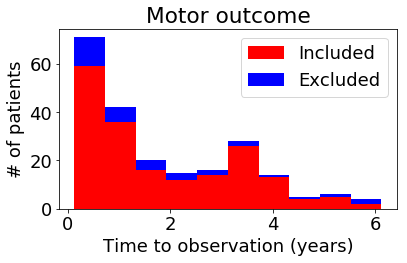

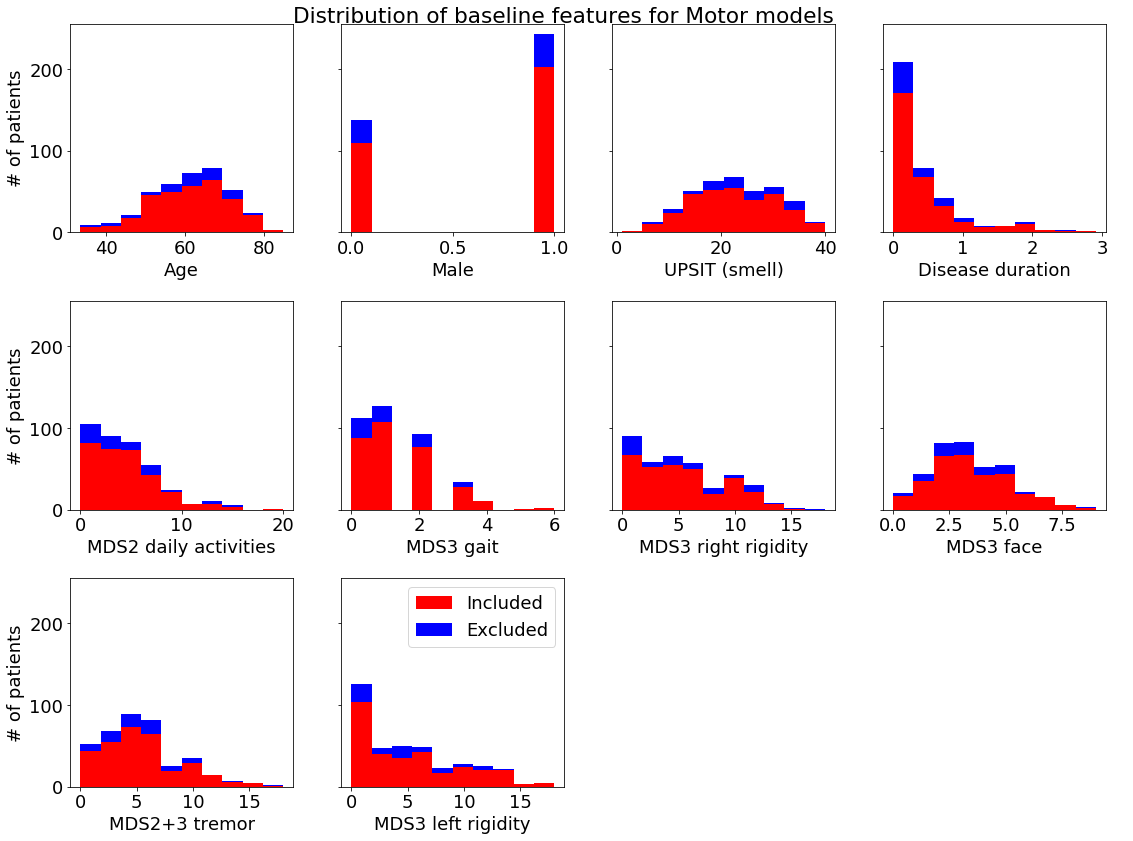

Cognitive
333 patients included and 64 patients excluded due to missing baseline covariates
Among included patients, 0.2643 observed with 1.6250 (1.7087) years to observation and 5.2270 (1.7136) years to censoring
Among excluded patients, 0.1875 observed with 1.5417 (1.6214) years to observation and 5.2780 (1.6640) years to censoring


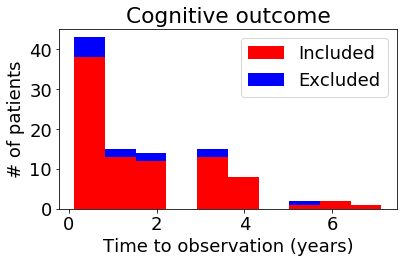

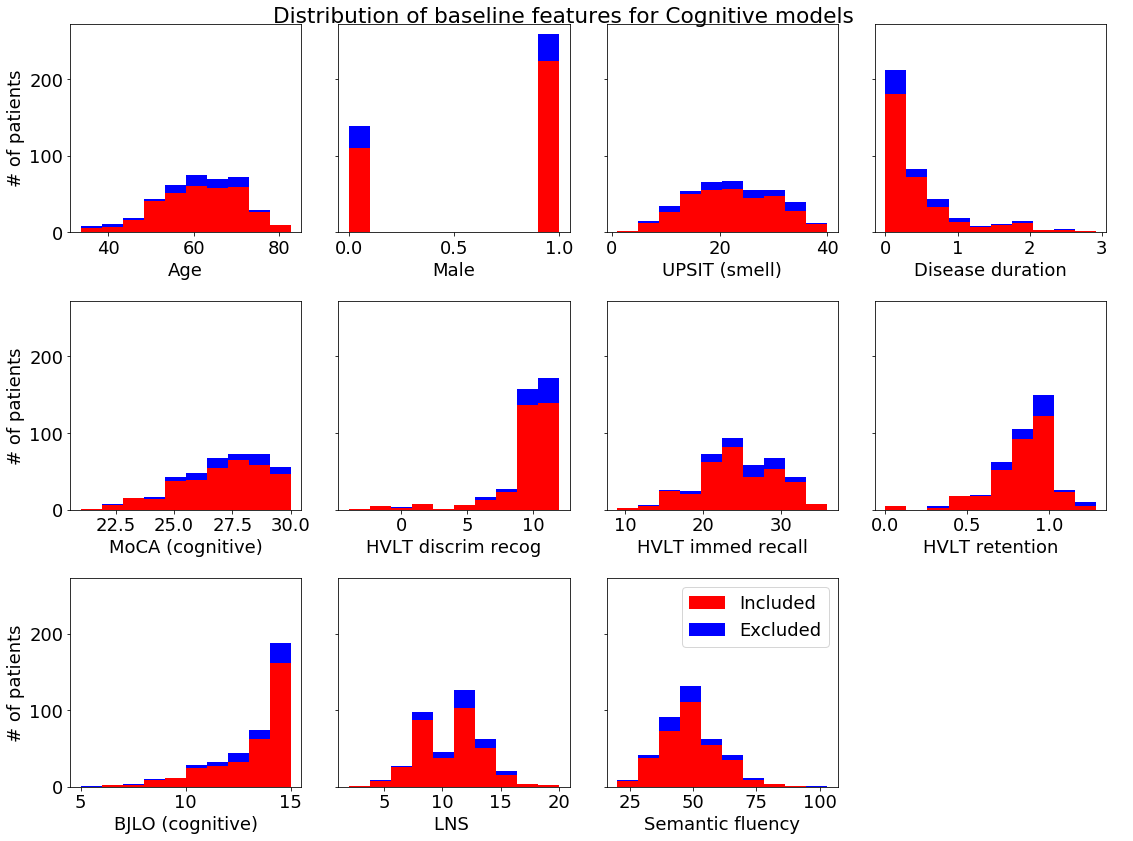

Autonomic
297 patients included and 121 patients excluded due to missing baseline covariates
Among included patients, 0.6364 observed with 1.2204 (1.5692) years to observation and 4.5231 (1.9986) years to censoring
Among excluded patients, 0.5702 observed with 1.4583 (1.6103) years to observation and 4.9110 (2.0064) years to censoring


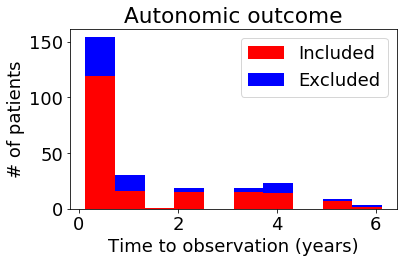

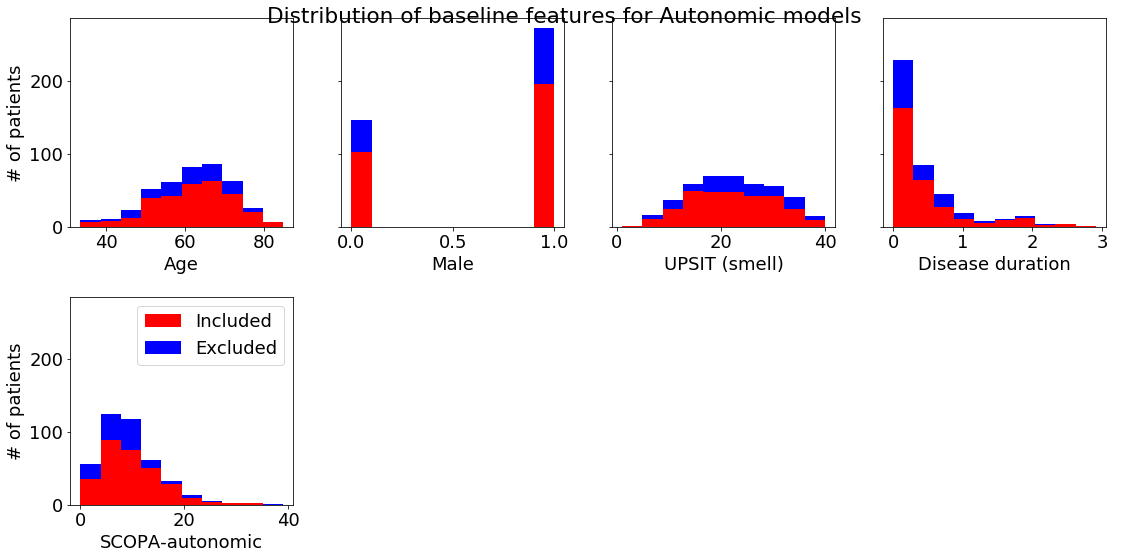

Psychiatric
296 patients included and 119 patients excluded due to missing baseline covariates
Among included patients, 0.7365 observed with 2.1565 (2.0726) years to observation and 3.3584 (1.8351) years to censoring
Among excluded patients, 0.7731 observed with 2.6680 (2.1253) years to observation and 3.8380 (1.6980) years to censoring


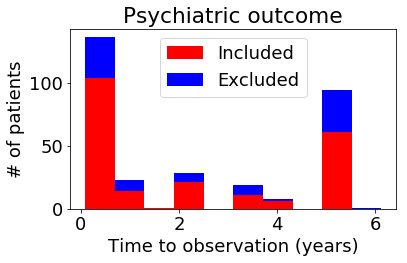

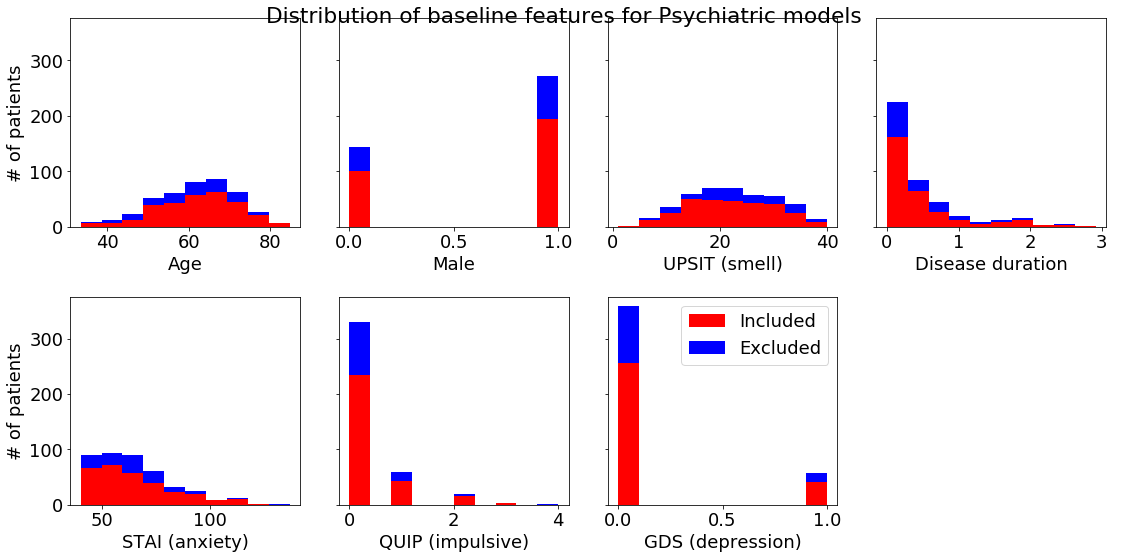

Sleep
345 patients included and 71 patients excluded due to missing baseline covariates
Among included patients, 0.6377 observed with 1.3682 (1.6688) years to observation and 4.6470 (1.8448) years to censoring
Among excluded patients, 0.5915 observed with 1.4097 (1.5787) years to observation and 4.6422 (2.0809) years to censoring


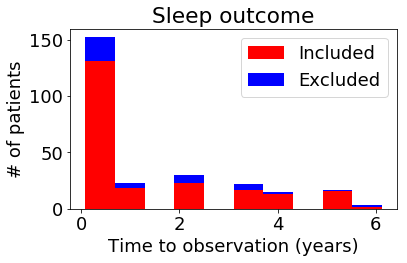

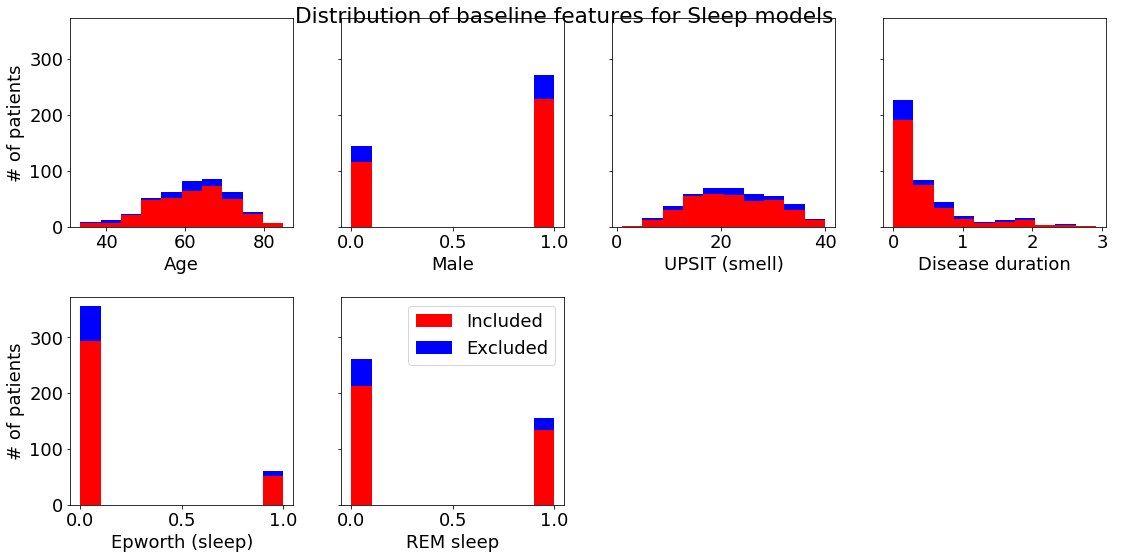

Hybrid
295 patients included and 121 patients excluded due to missing baseline covariates
Among included patients, 0.5627 observed with 2.0751 (1.7260) years to observation and 4.4777 (1.8824) years to censoring
Among excluded patients, 0.4132 observed with 2.7941 (1.9439) years to observation and 4.7764 (1.8344) years to censoring


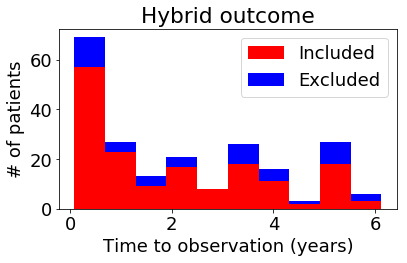

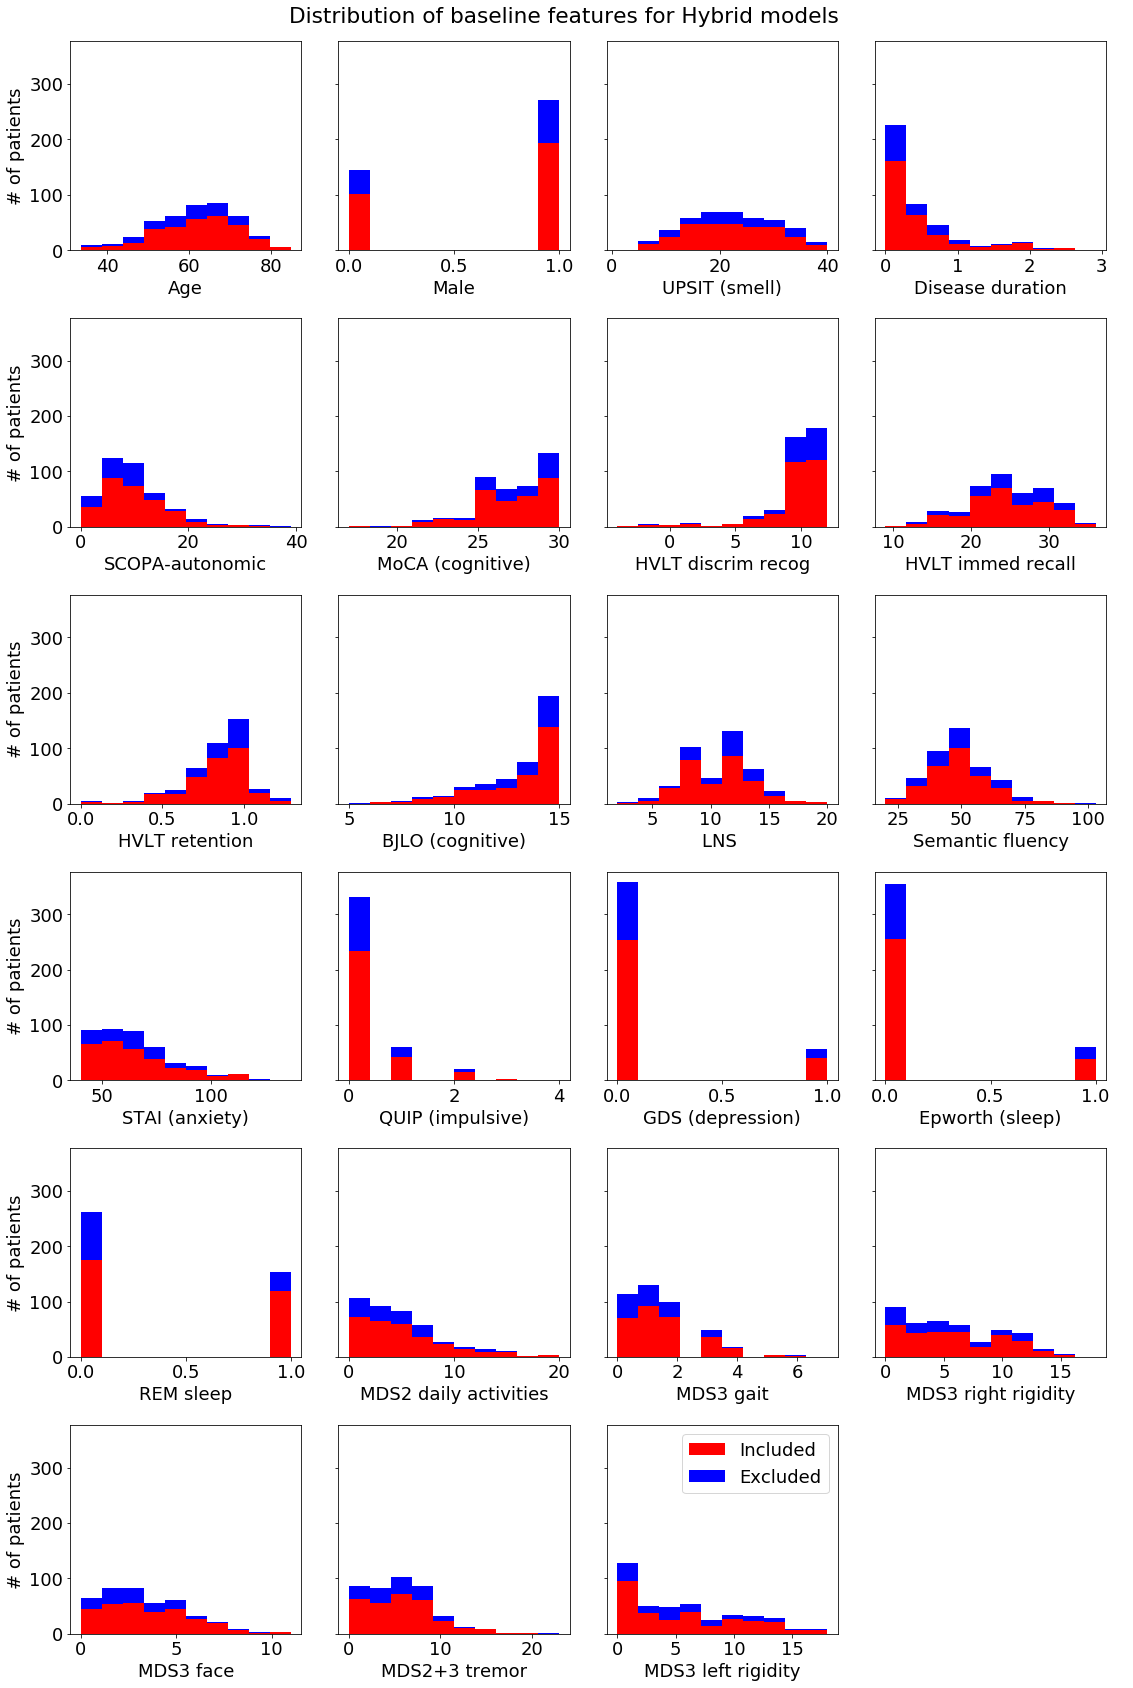

In [11]:
plt.rcParams.update({'font.size': 18})
for outcome in outcomes:
    print(outcome)
    if outcome == 'Hybrid':
        selected_baseline_feats = []
        plottable_baseline_feats = []
        for cov_set in union_of_covariate_sets.values():
            selected_baseline_feats += cov_set
        for cov_set in baseline_covariate_sets.values():
            plottable_baseline_feats += cov_set
    else:
        selected_baseline_feats = union_of_covariate_sets['All'] + union_of_covariate_sets['CSF'] \
            + union_of_covariate_sets['Imaging'] + union_of_covariate_sets[outcome]
        plottable_baseline_feats = baseline_covariate_sets['All'] + baseline_covariate_sets[outcome]
    nonzero_outcome_df = outcome_df.loc[outcome_df[outcome + '_T']>0][['PATNO', outcome + '_T', outcome + '_E']]
    selected_baseline_df = baseline_df[['PATNO']+selected_baseline_feats]
    nonzero_merged_df = nonzero_outcome_df.merge(selected_baseline_df, validate='one_to_one')
    nonzero_nomissing_merged_df = nonzero_merged_df.dropna()
    nomissing_patnos = nonzero_nomissing_merged_df.PATNO.values
    nonzero_hasmissing_merged_df = nonzero_merged_df.loc[~nonzero_merged_df['PATNO'].isin(nomissing_patnos)]
    # print # of patients in each, obs vs cens, avg times for both, distrib of obs times (stacked histogram)
    # set of histograms for distributions of each covariate selected
    print(str(len(nonzero_nomissing_merged_df)) + ' patients included and ' \
          + str(len(nonzero_hasmissing_merged_df)) + ' patients excluded due to missing baseline covariates')
    prop_obs_nomissing = nonzero_nomissing_merged_df[outcome+'_E'].sum()/float(len(nonzero_nomissing_merged_df))
    avg_obs_time_nomissing \
        = nonzero_nomissing_merged_df.loc[nonzero_nomissing_merged_df[outcome+'_E']==1][outcome+'_T'].mean()
    std_obs_time_nomissing \
        = nonzero_nomissing_merged_df.loc[nonzero_nomissing_merged_df[outcome+'_E']==1][outcome+'_T'].std()
    avg_cens_time_nomissing \
        = nonzero_nomissing_merged_df.loc[nonzero_nomissing_merged_df[outcome+'_E']==0][outcome+'_T'].mean()
    std_cens_time_nomissing \
        = nonzero_nomissing_merged_df.loc[nonzero_nomissing_merged_df[outcome+'_E']==0][outcome+'_T'].std()
    print('Among included patients, {0:.4f}'.format(prop_obs_nomissing) \
          + ' observed with {0:.4f}'.format(avg_obs_time_nomissing) + ' ({0:.4f})'.format(std_obs_time_nomissing) \
          + ' years to observation and {0:.4f}'.format(avg_cens_time_nomissing) \
          + ' ({0:.4f})'.format(std_cens_time_nomissing) + ' years to censoring')
    prop_obs_hasmissing = nonzero_hasmissing_merged_df[outcome+'_E'].sum()/float(len(nonzero_hasmissing_merged_df))
    avg_obs_time_hasmissing \
        = nonzero_hasmissing_merged_df.loc[nonzero_hasmissing_merged_df[outcome+'_E']==1][outcome+'_T'].mean()
    std_obs_time_hasmissing \
        = nonzero_hasmissing_merged_df.loc[nonzero_hasmissing_merged_df[outcome+'_E']==1][outcome+'_T'].std()
    avg_cens_time_hasmissing \
        = nonzero_hasmissing_merged_df.loc[nonzero_hasmissing_merged_df[outcome+'_E']==0][outcome+'_T'].mean()
    std_cens_time_hasmissing \
        = nonzero_hasmissing_merged_df.loc[nonzero_hasmissing_merged_df[outcome+'_E']==0][outcome+'_T'].std()
    print('Among excluded patients, {0:.4f}'.format(prop_obs_hasmissing) \
          + ' observed with {0:.4f}'.format(avg_obs_time_hasmissing) + ' ({0:.4f})'.format(std_obs_time_hasmissing) \
          + ' years to observation and {0:.4f}'.format(avg_cens_time_hasmissing) \
          + ' ({0:.4f})'.format(std_cens_time_hasmissing) + ' years to censoring')
    plt.hist([nonzero_nomissing_merged_df.loc[nonzero_nomissing_merged_df[outcome+'_E']==1][outcome+'_T'].values, \
              nonzero_hasmissing_merged_df.loc[nonzero_hasmissing_merged_df[outcome+'_E']==1][outcome+'_T'].values], \
             label=['Included', 'Excluded'], color=['red','blue'], stacked=True)
    plt.xlabel('Time to observation (years)')
    plt.ylabel('# of patients')
    plt.title(outcome + ' outcome')
    plt.legend()
    plt.tight_layout()
    plt.savefig('Inc_Exc_' + outcome + '_obs_times.pdf')
    plt.show()
    nrows = int((len(plottable_baseline_feats)-1)/4)+1
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(16, nrows*4), sharey=True)
    for idx in range(len(plottable_baseline_feats)):
        feat_ax = ax[int(idx/4), int(idx%4)]
        feat_name = plottable_baseline_feats[idx]
        feat_ax.hist([nonzero_nomissing_merged_df[feat_name].values, \
                      nonzero_hasmissing_merged_df[feat_name].dropna().values], \
                     label=['Included', 'Excluded'], color=['red','blue'], stacked=True)
        feat_ax.set_xlabel(human_readable_feat_dict[feat_name])
        if idx%4 == 0:
            feat_ax.set_ylabel('# of patients')
    for idx in range(len(plottable_baseline_feats), nrows*4):
        extra_ax = ax[int(idx/4), int(idx%4)]
        extra_ax.set_axis_off()
    feat_ax.legend()
    fig.suptitle('Distribution of baseline features for ' + outcome + ' models')
    fig.tight_layout()
    fig.subplots_adjust(top=0.96)
    plt.savefig('Inc_Exc_' + outcome + '_baseline_distribs.pdf')
    plt.show()

In [6]:
test_patnos_dict = dict()
train_patnos_dict = dict()
np.random.seed(2033)
for outcome in outcomes:
    if outcome == 'Hybrid':
        selected_baseline_feats = []
        for cov_set in union_of_covariate_sets.values():
            selected_baseline_feats += cov_set   
    else:
        selected_baseline_feats = union_of_covariate_sets['All'] + union_of_covariate_sets['CSF'] \
            + union_of_covariate_sets['Imaging'] + union_of_covariate_sets[outcome]
    nonzero_outcome_df = outcome_df.loc[outcome_df[outcome + '_T']>0][['PATNO', outcome + '_T', outcome + '_E']]
    selected_baseline_df = baseline_df[['PATNO']+selected_baseline_feats]
    nonzero_merged_df = nonzero_outcome_df.merge(selected_baseline_df, validate='one_to_one')
    nonzero_nomissing_merged_df = nonzero_merged_df.dropna()
    nomissing_patnos = nonzero_nomissing_merged_df.PATNO.values
    np.random.shuffle(nomissing_patnos)
    test_patnos = nomissing_patnos[int(.8*len(nomissing_patnos)):]
    test_patnos_dict[outcome] = test_patnos
    all_patnos = set(nonzero_outcome_df.PATNO.values.tolist())
    train_patnos_dict[outcome] = np.array(list(all_patnos.difference(test_patnos)))
    print(outcome + ': ' + str(len(nomissing_patnos)) + ' patients with no missing features, ' \
          + str(len(test_patnos)) + ' patients in test set')

Motor: 311 patients with no missing features, 63 patients in test set
Cognitive: 333 patients with no missing features, 67 patients in test set
Autonomic: 297 patients with no missing features, 60 patients in test set
Psychiatric: 296 patients with no missing features, 60 patients in test set
Sleep: 345 patients with no missing features, 69 patients in test set
Hybrid: 295 patients with no missing features, 59 patients in test set


In [7]:
test_patnos_dict['hybrid_requiremotor'] = test_patnos_dict['Hybrid']
del test_patnos_dict['Hybrid']
test_patnos_dict.keys()

['Autonomic',
 'Cognitive',
 'Psychiatric',
 'Sleep',
 'Motor',
 'hybrid_requiremotor']

In [8]:
with open('Inc_Exc_Test_Patnos.pkl', 'w') as f:
    pickle.dump(test_patnos_dict, f)

In [11]:
from lifelines.utils import concordance_index
def calc_maes(df, outcome):
    assert {outcome + '_T', outcome + '_E', outcome + '_T_pred'}.issubset(set(df.columns.values.tolist()))
    obs_df = df.loc[df[outcome + '_E']==1]
    cens_df = df.loc[df[outcome + '_E']==0]
    if len(obs_df) > 0:
        obs_mae = ((obs_df[outcome + '_T'] - obs_df[outcome + '_T_pred'])).abs().mean()
    else:
        obs_mae = 0
    if len(cens_df) > 0:
        cens_mae = np.mean(np.where(cens_df[outcome + '_T_pred'] < cens_df[outcome + '_T'], \
                           np.abs(cens_df[outcome + '_T_pred'] - cens_df[outcome + '_T']), 0))
    else:
        cens_mae = 0
    mae = (len(obs_df)*obs_mae + len(cens_df)*cens_mae)/len(df)
    return obs_mae, cens_mae, mae

def get_ci_mae(pred_df, outcome):
    ci = concordance_index(pred_df[outcome + '_T'], pred_df[outcome + '_T_pred'], pred_df[outcome + '_E'])
    _, _, mae = calc_maes(pred_df, outcome)
    return ci, mae

In [14]:
test_patnos_dict['Hybrid'] = test_patnos_dict['hybrid_requiremotor']

In [15]:
# Predict median time to outcome - MAE + CI (CI should be bad unless ties make a huge difference)
print('Metrics for predicting median observation time')
for outcome in outcomes:
    median_obs_time = outcome_df.loc[np.logical_and(outcome_df['PATNO'].isin(set(train_patnos_dict[outcome].tolist())), \
                                                    outcome_df[outcome + '_E']==1)][outcome + '_T'].quantile(q=0.5)
    test_df = outcome_df.loc[outcome_df['PATNO'].isin(set(test_patnos_dict[outcome].tolist()))]
    pred_df = test_df[[outcome + '_E', outcome + '_T']]
    pred_df[outcome + '_T_pred'] = median_obs_time
    ci, mae = get_ci_mae(pred_df, outcome)
    print(outcome + ': CI: {0:.4f}'.format(ci) + ', MAE: {0:.4f}'.format(mae))

Metrics for predicting median observation time
Motor: CI: 0.5000, MAE: 2.3968
Cognitive: CI: 0.5000, MAE: 3.4030


/afs/csail.mit.edu/u/c/cji/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Autonomic: CI: 0.5000, MAE: 2.0750
Psychiatric: CI: 0.5000, MAE: 1.7910
Sleep: CI: 0.5000, MAE: 2.2536
Hybrid: CI: 0.5000, MAE: 1.7034
